In [1]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT, MOVEMENT
import numpy as np
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
piece_type_lookup = {
    'Tu': 'T', 'Tr': 'T', 'Td': 'T', 'Tl': 'T',
    'Jl': 'J', 'Ju': 'J', 'Jr': 'J', 'Jd': 'J',
    'Zh': 'Z', 'Zv': 'Z',
    'O': 'O',
    'Sh': 'S', 'Sv': 'S',
    'Lr': 'L', 'Ld': 'L', 'Ll': 'L', 'Lu': 'L',
    'Iv': 'I', 'Ih': 'I',
    'none': 'none'
}

In [3]:
tetris_start_positions = {
    'Tu': (-2, 4),  # Top of 'T' piece, up orientation, centered
    'Tr': (-2, 4),  # Top of 'T' piece, right orientation, centered
    'Td': (-2, 4),  # Top of 'T' piece, down orientation, centered
    'Tl': (-2, 4),  # Top of 'T' piece, left orientation, centered
    'Jl': (-2, 4),  # Top of 'J' piece, left orientation, centered
    'Ju': (-2, 4),  # Top of 'J' piece, up orientation, centered
    'Jr': (-2, 4),  # Top of 'J' piece, right orientation, centered
    'Jd': (-2, 4),  # Top of 'J' piece, down orientation, centered
    'Zh': (-2, 4),  # Top of 'Z' piece, horizontal orientation, centered
    'Zv': (-2, 4),  # Top of 'Z' piece, vertical orientation, centered
    'O':  (-2, 4),  # Top of 'O' piece, centered
    'Sh': (-2, 4),  # Top of 'S' piece, horizontal orientation, centered
    'Sv': (-2, 4),  # Top of 'S' piece, vertical orientation, centered
    'Lr': (-2, 4),  # Top of 'L' piece, right orientation, centered
    'Ld': (-2, 4),  # Top of 'L' piece, down orientation, centered
    'Ll': (-2, 4),  # Top of 'L' piece, left orientation, centered
    'Lu': (-2, 4),  # Top of 'L' piece, up orientation, centered
    # Top of 'I' piece, vertical orientation, slightly left centered to fit 4 blocks
    'Iv': (-4, 3),
    # Top of 'I' piece, horizontal orientation, slightly left centered to fit 4 blocks
    'Ih': (-1, 3)
}

In [4]:
def statePreprocess(state):
    # the shape of the play area is from 48 to 208 in the x direction and 96 to 176 in the y direction
    state = state[48:208, 96:176]
    grayscale = np.dot(state[..., :3], [0.2989, 0.5870, 0.1140])
    binary_array = grayscale.reshape(20, 8, 10, 8).max(axis=(1, 3)) > 0
    return binary_array.astype(int)

In [5]:
def calculate_heights(grid):
    # This function finds the height of each column in the grid.
    # It calculates height from the bottom to the first non-zero cell encountered from the top.
    heights = np.zeros(grid.shape[1], dtype=int)
    for col in range(grid.shape[1]):
        column = grid[:, col]  # Extract the entire column
        first_filled = np.where(column > 0)[0]
        if first_filled.size > 0:
            heights[col] = grid.shape[0] - first_filled.min()
    return heights

In [6]:
def clear_piece_from_board(board, piece_shape, start_position):
    """
    Clear the piece from the board using vectorized operations.
    
    :param board: Current state of the game board as a NumPy array.
    :param piece_shape: Numpy array representing the shape of the piece.
    :param start_position: Tuple (start_row, start_col) indicating where the piece starts.
    """
    start_row, start_col = start_position
    piece_height, piece_width = piece_shape.shape

    # Create a mask for the piece within the bounds of the board
    row_indices = np.arange(start_row, start_row + piece_height)
    col_indices = np.arange(start_col, start_col + piece_width)

    # Filter out indices that are out of bounds
    valid_rows = (row_indices >= 0) & (row_indices < board.shape[0])
    valid_cols = (col_indices >= 0) & (col_indices < board.shape[1])

    # Use only valid rows and columns
    valid_row_indices = row_indices[valid_rows]
    valid_col_indices = col_indices[valid_cols]

    # Clear the piece on the board using a mask
    board[valid_row_indices[:, None],
          valid_col_indices] -= piece_shape[valid_rows, :][:, valid_cols]

    # Ensure no negative values remain if there are overlaps or other artifacts
    board[board < 0] = 0

    return board


In [7]:
def get_fixedState_heightDiff(oldInfo, oldState):
    # This function finds the number of filled cells that have no empty cells below them.
    # These are the fixed blocks in the grid.
    prev_piece = oldInfo['current_piece']
    prev_piece = oldInfo['current_piece']
    start_row, start_col = tetris_start_positions[prev_piece]
    piece_array = np.zeros_like(oldState)
    piece_height, piece_width = piece_array.shape

    fixBoard = clear_piece_from_board(oldState, piece_array, (start_row, start_col))+oldState
    fixBoard = fixBoard > 0
    
    heights = calculate_heights(fixBoard)
    
    return fixBoard, heights

In [8]:
env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()

/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


In [9]:
def merge_states(old_state, new_state, old_info, new_info):
    """
    Merge old_state and new_state based on piece transitions.

    Args:
    old_state (array): The previous state of the environment.
    new_state (array): The current state of the environment after taking an action.
    old_info (dict): Information about the previous state (e.g., 'current_piece', 'next_piece').
    new_info (dict): Information about the current state.

    Returns:
    np.array: The merged state where both states are combined appropriately.
    """
    default_piece_type = 'none'
    merged_state = np.zeros_like(old_state)
    if (piece_type_lookup.get(old_info['current_piece'], default_piece_type) != 
        piece_type_lookup.get(new_info['current_piece'], default_piece_type) or
        piece_type_lookup.get(old_info['next_piece'], default_piece_type) != 
        piece_type_lookup.get(new_info['next_piece'], default_piece_type)):

        if old_info['current_piece'] != 'none':
            prev_piece = old_info['current_piece']
            start_row, start_col = tetris_start_positions[prev_piece]

            piece_array = np.zeros_like(old_state)
            for r in range(20):
                for c in range(10):
                    if start_row + r < 0 or start_row + r >= 20 or start_col + c < 0 or start_col + c >= 10:
                        continue
                    if old_state[start_row + r, start_col + c] == 1:
                        old_state[start_row + r, start_col + c] = 0

            merged_state = old_state + new_state
            merged_state[merged_state > 1] = 1
        #plot the merged state
        plt.imshow(merged_state)
        plt.show()

    return merged_state

/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


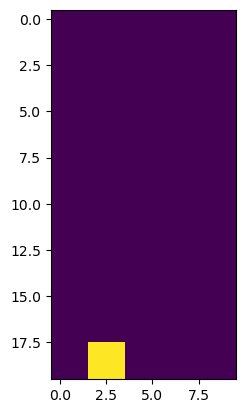

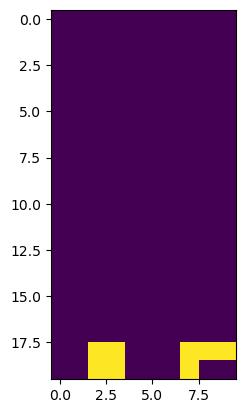

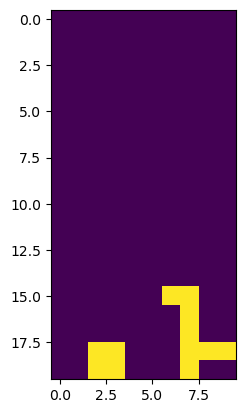

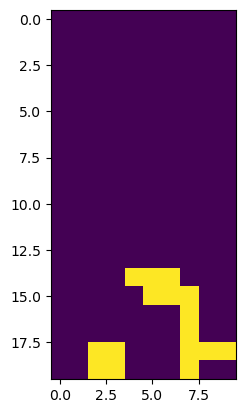

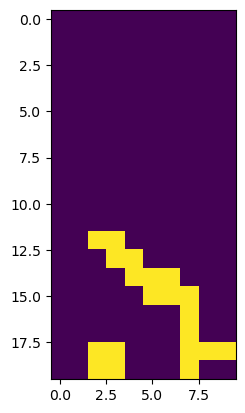

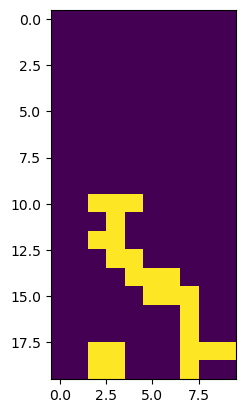

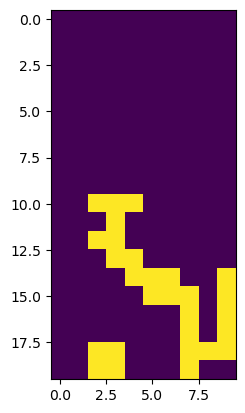

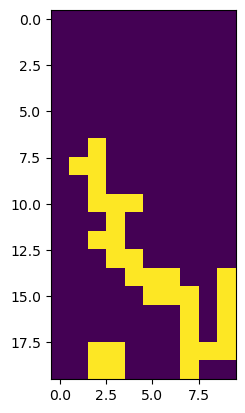

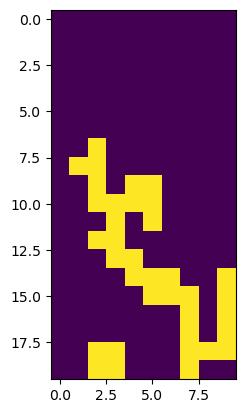

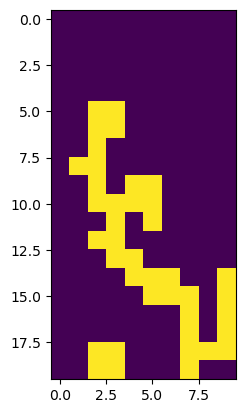

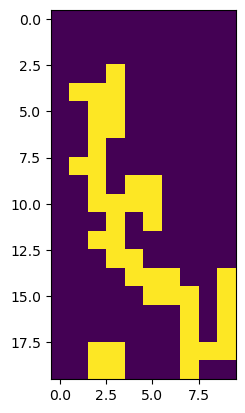

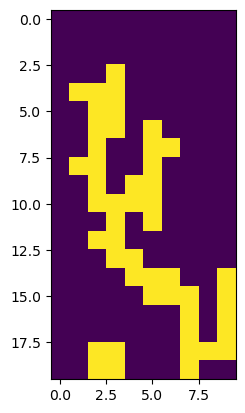

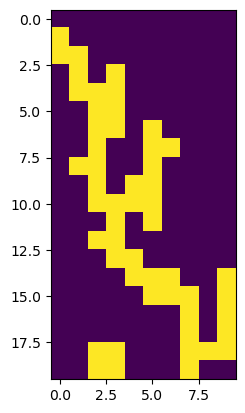

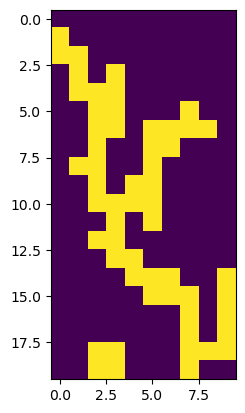

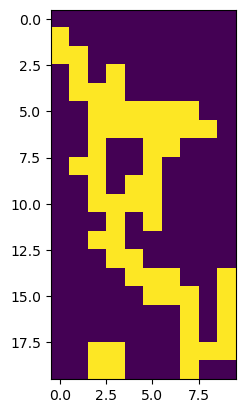

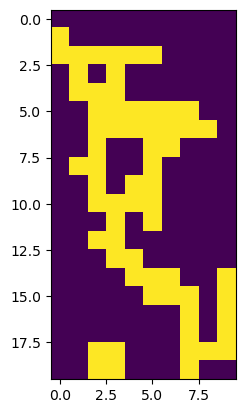

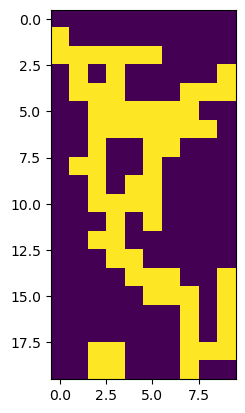

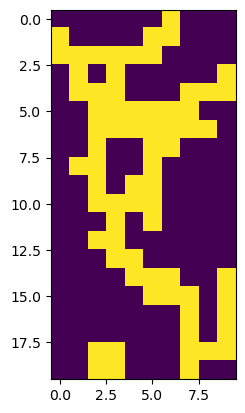

In [10]:

# Reset the environment to start
oldState, _, done, oldInfo = env.step(0)
oldState = statePreprocess(oldState)
newInfo = {'current_piece': 'none', 'next_piece': 'none'}


while not done:
    # Check if we need to force the first action to be '0' for a new piece
    if (piece_type_lookup[oldInfo['current_piece']] != piece_type_lookup[newInfo['current_piece']] or
        piece_type_lookup[oldInfo['next_piece']] != piece_type_lookup[newInfo['next_piece']]):
        action = 0  # Force first action to be '0' when a new piece is detected
    else:
        action =action = random.randint(0, 5) # Otherwise choose a random action

    # Step in the environment using the selected action
    newState, reward, done, newInfo = env.step(action)
    newState = statePreprocess(newState)  # Preprocess the new state

    # Merge the old and new states based on piece transitions
    mergedState = merge_states(oldState, newState, oldInfo, newInfo)
    
    

    # Update old info and state
    oldInfo = newInfo
    oldState = newState

    env.render()  # Render the game
    if done:
        break  # Exit the loop if the game is over
    
env.close()  # Close the environment

In [11]:

# Reset the environment to start
oldState, _, done, oldInfo = env.step(0)
oldState = statePreprocess(oldState)
newInfo = {'current_piece': 'none', 'next_piece': 'none'}


while not done:
    # Check if we need to force the first action to be '0' for a new piece
    if (piece_type_lookup[oldInfo['current_piece']] != piece_type_lookup[newInfo['current_piece']] or
        piece_type_lookup[oldInfo['next_piece']] != piece_type_lookup[newInfo['next_piece']]):
        action = 0  # Force first action to be '0' when a new piece is detected
    else:
        action =action = random.randint(0, 5) # Otherwise choose a random action

    # Step in the environment using the selected action
    newState, reward, done, newInfo = env.step(action)
    newState = statePreprocess(newState)  # Preprocess the new state

    if (piece_type_lookup[oldInfo['current_piece']] != piece_type_lookup[newInfo['current_piece']] or
        piece_type_lookup[oldInfo['next_piece']] != piece_type_lookup[newInfo['next_piece']]):
        # Detect change in the piece
        if oldInfo['current_piece'] != 'none':
            # Get the previous piece and its start position
            prev_piece = oldInfo['current_piece']
            start_row, start_col = tetris_start_positions[prev_piece]

            # Calculate piece dimensions and remove it from the old state
            piece_array = np.zeros_like(oldState)  # Placeholder for actual piece shape removal
            for r in range(20):  # Assuming board height is 20
                for c in range(10):  # Assuming board width is 10
                    if start_row + r < 0 or start_row + r >= 20 or start_col + c < 0 or start_col + c >= 10:
                        continue
                    if oldState[start_row + r, start_col + c] == 1:
                        oldState[start_row + r, start_col + c] = 0

            # Merge with new state
            mergedState = oldState + newState
            mergedState[mergedState > 1] = 1  # Ensure the board does not have overlapping pieces

            # Calculate height difference
            heightDiff = calculate_heights(mergedState)
            print("Height differences:", heightDiff)

            # Display the current state
            plt.imshow(mergedState, cmap='gray')
            plt.show()

        # Update old info and state
        oldInfo = newInfo
        oldState = newState

    env.render()  # Render the game
    if done:
        break  # Exit the loop if the game is over
    
env.close()  # Close the environment


ValueError: cannot step in a done environment! call `reset`

In [ ]:
# # oldInfo = {"current_piece": 'none', "next_piece": 'none'}
# # oldState = np.zeros((20, 10))
# oldState,_,done,oldInfo = env.step(0)
# oldState = statePreprocess(oldState)

# while not done:
#     action = random.choice(SIMPLE_MOVEMENT)
#     newState, reward, done, newInfo = env.step(0)  # Execute a random action
#     newState = statePreprocess(newState)  # Preprocess the new state
    
#     if (piece_type_lookup[oldInfo['current_piece']] != piece_type_lookup[newInfo['current_piece']] or
#             oldInfo['current_piece'] != newInfo['current_piece']):
#         # Detect change in the piece
#         if oldInfo['current_piece'] != 'none':
#             # Get the previous piece and its start position
#             prev_piece = oldInfo['current_piece']
#             start_row, start_col = tetris_start_positions[prev_piece]
#             # Adjust for actual board size and orientation specifics
#             piece_array = np.zeros_like(oldState)
#             piece_height, piece_width = piece_array.shape

#             # Remove the piece from the old state
#             for r in range(piece_height):
#                 for c in range(piece_width):
#                     if start_row + r < 0 or start_row + r >= 20 or start_col + c < 0 or start_col + c >= 10:
#                         continue
#                     if oldState[start_row + r, start_col + c] == 1:
#                         oldState[start_row + r, start_col + c] = 0

#             # Merge with new state
#             mergedState = oldState + newState  # This operation might need adjustments based on your game logic
#             mergedState[mergedState > 1] = 1
#             #calculate the height difference
#             heightDiff = calculate_heights(mergedState)
#             print(heightDiff)

#             # Display the current state
#             plt.imshow(mergedState, cmap='gray')
#             plt.show()
#             print("Change in piece detected")

#         # Update old info and state
#         oldInfo = newInfo
#         oldState = newState
    
#     env.render()  # Render the game
#     if done:
#         break  # Exit the loop if the game is over
    
# env.close()  # Close the environment